In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np

In [ ]:
data = pd.read_csv('dataset2new.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  271 non-null    int64  
 1   date        271 non-null    object 
 2   co2         271 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.5+ KB


In [ ]:
data_cleaned = data.drop(columns=['Unnamed: 0'])
data_cleaned['date'] = pd.to_datetime(data_cleaned['date'])
data_cleaned.set_index('date', inplace=True)

In [ ]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 271 entries, 1750-12-31 to 2020-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     271 non-null    float64
dtypes: float64(1)
memory usage: 4.2 KB


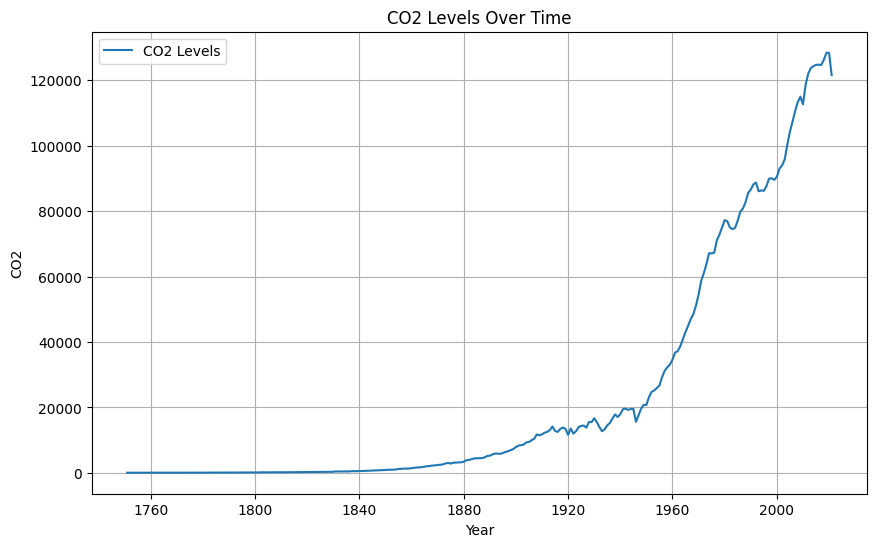

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data_cleaned.index, data_cleaned['co2'], label='CO2 Levels')
plt.title('CO2 Levels Over Time')
plt.xlabel('Year')
plt.ylabel('CO2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
adf_test = adfuller(data_cleaned['co2'])
print("ADF Test Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])

ADF Test Statistic: 0.3746178793815761
p-value: 0.980520521311717
Critical Values: {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}


In [ ]:
data_cleaned['co2_diff'] = data_cleaned['co2'].diff()

In [ ]:
adf_test_diff = adfuller(data_cleaned['co2_diff'].dropna())
print("\nDifferenced Data ADF Test Statistic:", adf_test_diff[0])
print("p-value:", adf_test_diff[1])
print("Critical Values:", adf_test_diff[4])


Differenced Data ADF Test Statistic: -2.6305136667259634
p-value: 0.08685326403600796
Critical Values: {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}


In [ ]:
data_cleaned['co2_diff2'] = data_cleaned['co2_diff'].diff()

In [ ]:
second_diff_data = data_cleaned['co2_diff2'].dropna()

In [ ]:
adf_test_diff2 = adfuller(second_diff_data)
print("\nSecond-Order Differenced Data ADF Test Statistic:", adf_test_diff2[0])
print("p-value:", adf_test_diff2[1])
print("Critical Values:", adf_test_diff2[4])


Second-Order Differenced Data ADF Test Statistic: -3.5163945233470773
p-value: 0.007575896511914773
Critical Values: {'1%': -3.4565688966099373, '5%': -2.8730786194395455, '10%': -2.5729189953388762}


In [ ]:
data_cleaned['log_co2'] = np.log(data_cleaned['co2'])

data_cleaned['log_co2_diff'] = data_cleaned['log_co2'].diff()

data_cleaned['log_co2_diff2'] = data_cleaned['log_co2_diff'].diff().dropna()

adf_test_log_diff2 = adfuller(data_cleaned['log_co2_diff2'].dropna())
print("\nLog Transformed Second Differenced ADF Test Statistic:", adf_test_log_diff2[0])
print("p-value:", adf_test_log_diff2[1])
print("Critical Values:", adf_test_log_diff2[4])

if adf_test_log_diff2[1] < 0.05:
    print("\nThe series is stationary (p-value < 0.05).")
else:
    print("\nThe series is not stationary (p-value >= 0.05).")


Log Transformed Second Differenced ADF Test Statistic: -8.424195137895088
p-value: 1.9467667955639438e-13
Critical Values: {'1%': -3.4562572510874396, '5%': -2.8729420379793598, '10%': -2.5728461399461744}

The series is stationary (p-value < 0.05).


In [ ]:
model = ARIMA(data_cleaned['log_co2'], order=(1, 2, 1))
arima_result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)


In [ ]:
forecast_steps = 12
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(data_cleaned.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

<ipython-input-110-b05a4e69e06b>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(data_cleaned.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


In [ ]:
forecast_log = forecast.predicted_mean
forecast_original = np.exp(forecast_log)

In [ ]:
conf_int_log = forecast.conf_int()
conf_int_original = np.exp(conf_int_log)

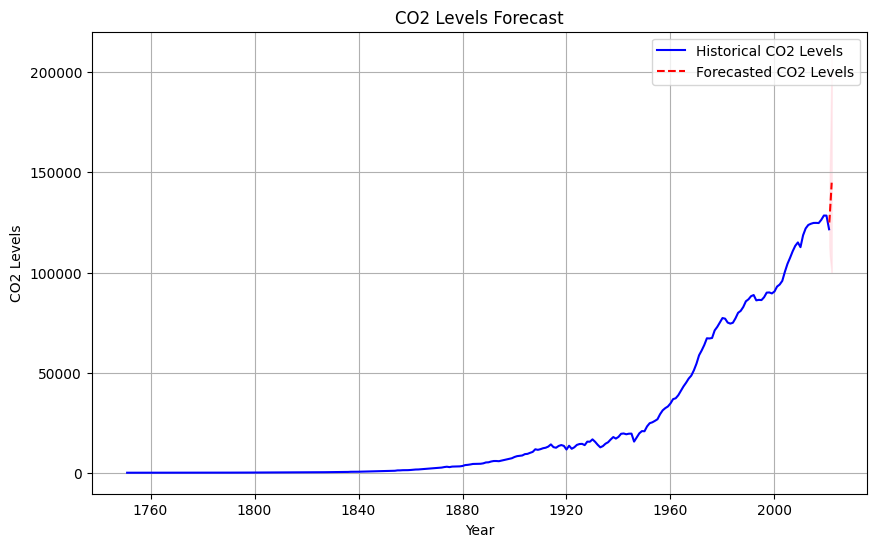

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data_cleaned.index, data_cleaned['co2'], label='Historical CO2 Levels', color='blue')
plt.plot(forecast_index, forecast_original, label='Forecasted CO2 Levels', color='red', linestyle='--')
plt.fill_between(forecast_index, conf_int_original.iloc[:, 0], conf_int_original.iloc[:, 1], color='pink', alpha=0.3)
plt.title('CO2 Levels Forecast')
plt.xlabel('Year')
plt.ylabel('CO2 Levels')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                log_co2   No. Observations:                  271
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 418.556
Date:                Fri, 15 Nov 2024   AIC                           -831.111
Time:                        08:15:07   BIC                           -820.327
Sample:                    12-31-1750   HQIC                          -826.781
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2013      0.047     -4.294      0.000      -0.293      -0.109
ma.L1         -0.9528      0.019    -49.125      0.000      -0.991      -0.915
sigma2         0.0026      0.000     22.323      0.0

In [ ]:
train_data = data_cleaned['log_co2'][:-forecast_steps]
test_data = data_cleaned['co2'][-forecast_steps:]

model_fit = ARIMA(train_data, order=(1, 2, 1)).fit()
forecast_test_log = model_fit.forecast(steps=forecast_steps)
forecast_test_original = np.exp(forecast_test_log)

mae = mean_absolute_error(test_data, forecast_test_original)
mape = mean_absolute_percentage_error(test_data, forecast_test_original)

print(f"\nMean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)



Mean Absolute Error (MAE): 9618.36
Mean Absolute Percentage Error (MAPE): 7.73%
